[INFO] Loaded drift metrics: 10 pairs
   Prompt_i  Prompt_j  Cosine_Similarity  Kendall_Tau
0         1         2           0.576554     0.382262
1         1         3           0.530887     0.355635
2         1         4           0.272693     0.165579
3         1         5           0.831176     0.621899
4         2         3           0.615947     0.415769
[INFO] Loaded activation overlap metrics: 360 records
   Layer  Prompt_i  Prompt_j  Cosine_Overlap
0      0         1         2        0.894531
1      0         1         3        0.902392
2      0         1         4        0.887207
3      0         1         5        0.884334
4      0         2         3        0.894095
[INFO] Merged dataset shape: (10, 5)

[RESULTS] Correlation between Semantic and Activation Stability
Pearson r (Cosine ↔ Overlap): 0.5467
Spearman ρ (Cosine ↔ Overlap): 0.6727
Pearson r (Kendall τ ↔ Overlap): 0.5356
Spearman ρ (Kendall τ ↔ Overlap): 0.6727

[INFO] Saved correlation summary → logs/correlation_sum

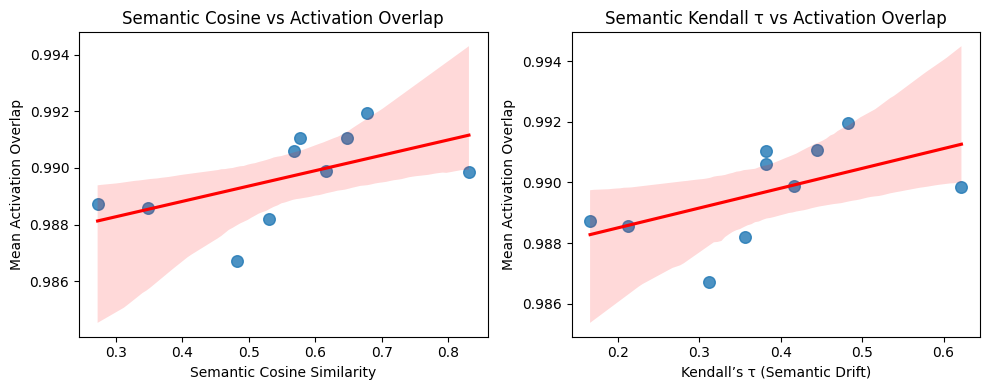

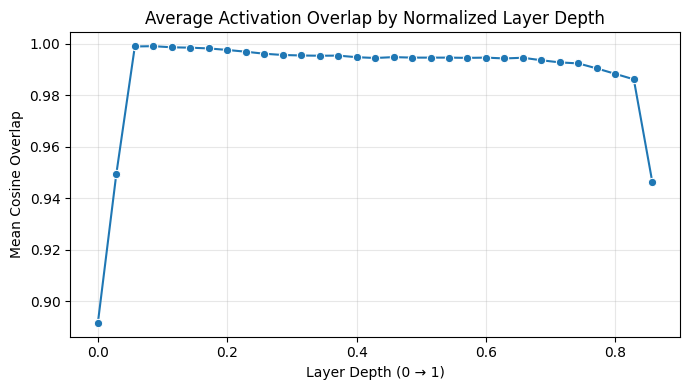

[INFO] Drift ↔ Overlap Correlation Analysis complete.


In [1]:
#!/usr/bin/env python3
"""
Phase 4 — Drift ↔ Activation Overlap Correlation
Combines semantic drift metrics (cosine + Kendall’s τ)
with activation overlap metrics to quantify representational stability.
"""

import os, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# ---------------------------------------------------------------------
# 1. Load drift metrics (semantic space)
# ---------------------------------------------------------------------
drift_path = os.path.join("logs", "drift_summary.csv")
if not os.path.exists(drift_path):
    raise FileNotFoundError("Missing logs/drift_summary.csv — run drift_analysis.ipynb first.")
df_drift = pd.read_csv(drift_path)
print(f"[INFO] Loaded drift metrics: {len(df_drift)} pairs")
print(df_drift.head())

# ---------------------------------------------------------------------
# 2. Load activation overlap metrics (neuron space)
# ---------------------------------------------------------------------
overlap_path = os.path.join("activations", "activation_overlap_summary.csv")
if not os.path.exists(overlap_path):
    raise FileNotFoundError("Missing activations/activation_overlap_summary.csv — run activation_overlap.ipynb first.")
df_overlap = pd.read_csv(overlap_path)
print(f"[INFO] Loaded activation overlap metrics: {len(df_overlap)} records")
print(df_overlap.head())

# ---------------------------------------------------------------------
# 3. Average activation overlap per prompt-pair (across layers)
# ---------------------------------------------------------------------
df_overlap_mean = (
    df_overlap.groupby(["Prompt_i", "Prompt_j"])["Cosine_Overlap"]
    .mean()
    .reset_index()
    .rename(columns={"Cosine_Overlap": "Mean_Cosine_Overlap"})
)

# ---------------------------------------------------------------------
# 4. Merge semantic and activation metrics
# ---------------------------------------------------------------------
df_merged = pd.merge(
    df_drift,
    df_overlap_mean,
    on=["Prompt_i", "Prompt_j"],
    how="inner"
)
print(f"[INFO] Merged dataset shape: {df_merged.shape}")
df_merged.head()

# ---------------------------------------------------------------------
# 5. Compute correlations
# ---------------------------------------------------------------------
pear_cos, _ = pearsonr(df_merged["Cosine_Similarity"], df_merged["Mean_Cosine_Overlap"])
pear_tau, _ = pearsonr(df_merged["Kendall_Tau"], df_merged["Mean_Cosine_Overlap"])
spear_cos, _ = spearmanr(df_merged["Cosine_Similarity"], df_merged["Mean_Cosine_Overlap"])
spear_tau, _ = spearmanr(df_merged["Kendall_Tau"], df_merged["Mean_Cosine_Overlap"])

print("\n[RESULTS] Correlation between Semantic and Activation Stability")
print(f"Pearson r (Cosine ↔ Overlap): {pear_cos:.4f}")
print(f"Spearman ρ (Cosine ↔ Overlap): {spear_cos:.4f}")
print(f"Pearson r (Kendall τ ↔ Overlap): {pear_tau:.4f}")
print(f"Spearman ρ (Kendall τ ↔ Overlap): {spear_tau:.4f}")

# Save correlation summary
corr_out = pd.DataFrame({
    "Metric_Pair": ["Cosine↔Overlap", "Kendallτ↔Overlap"],
    "Pearson_r": [pear_cos, pear_tau],
    "Spearman_r": [spear_cos, spear_tau]
})
corr_out.to_csv(os.path.join("logs", "correlation_summary.csv"), index=False)
print("\n[INFO] Saved correlation summary → logs/correlation_summary.csv")

# ---------------------------------------------------------------------
# 6. Visualization A — Scatterplots
# ---------------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.regplot(data=df_merged,
            x="Cosine_Similarity", y="Mean_Cosine_Overlap",
            scatter_kws={"s":70}, line_kws={"color":"red"})
plt.title("Semantic Cosine vs Activation Overlap")
plt.xlabel("Semantic Cosine Similarity")
plt.ylabel("Mean Activation Overlap")

plt.subplot(1,2,2)
sns.regplot(data=df_merged,
            x="Kendall_Tau", y="Mean_Cosine_Overlap",
            scatter_kws={"s":70}, line_kws={"color":"red"})
plt.title("Semantic Kendall τ vs Activation Overlap")
plt.xlabel("Kendall’s τ (Semantic Drift)")
plt.ylabel("Mean Activation Overlap")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 7. Visualization B — Layerwise drift vs overlap trend (optional)
# ---------------------------------------------------------------------
# Flatten activation overlap per layer and merge again for per-layer correlations
layerwise = df_overlap.groupby("Layer")["Cosine_Overlap"].mean().reset_index()
layerwise["Layer_Normalized"] = layerwise["Layer"] / layerwise["Layer"].max()
plt.figure(figsize=(7,4))
sns.lineplot(data=layerwise, x="Layer_Normalized", y="Cosine_Overlap", marker="o")
plt.title("Average Activation Overlap by Normalized Layer Depth")
plt.xlabel("Layer Depth (0 → 1)")
plt.ylabel("Mean Cosine Overlap")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("[INFO] Drift ↔ Overlap Correlation Analysis complete.")
